# Statistical inference of stock returns with linear regression

## Imports & Settings

In [335]:
from pathlib import Path
from time import time
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf`
from scipy.stats import spearmanr, norm

from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, KFold

from empyrical import max_drawdown, sortino_ratio
from custom_scoring import spearman_corr

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings

In [156]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
idx = pd.IndexSlice

## Load Data

In [3]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [4]:
data = data[data.dollar_vol_rank<100]

In [5]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109667 entries, (AAL, 2013-07-25 00:00:00) to (ZTS, 2014-12-04 00:00:00)
Data columns (total 64 columns):
volume                   109667 non-null float64
dollar_vol               109667 non-null float64
dollar_vol_rank          109667 non-null float64
rsi                      109667 non-null float64
bb_high                  109667 non-null float64
bb_low                   109667 non-null float64
atr                      109667 non-null float64
macd                     109667 non-null float64
return_1d                109667 non-null float64
return_5d                109667 non-null float64
return_10d               109667 non-null float64
return_21d               109667 non-null float64
return_42d               109667 non-null float64
return_63d               109667 non-null float64
return_1d_lag1           109667 non-null float64
return_5d_lag1           109667 non-null float64
return_10d_lag1          109667 non-null float64
return_21d_

### Create Model Data

In [7]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)

## Explore Data

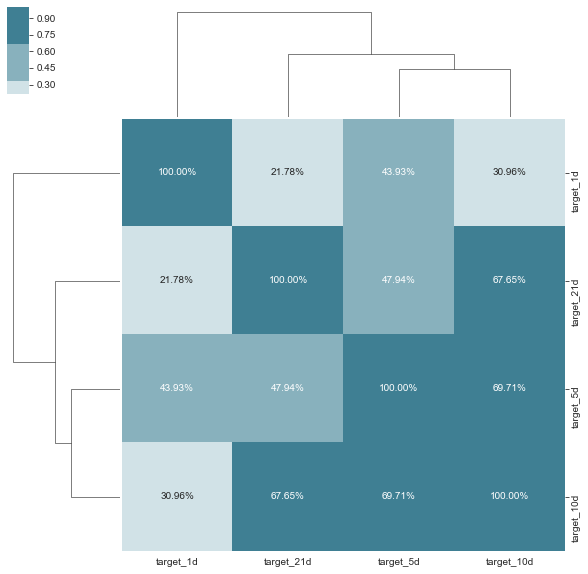

In [7]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

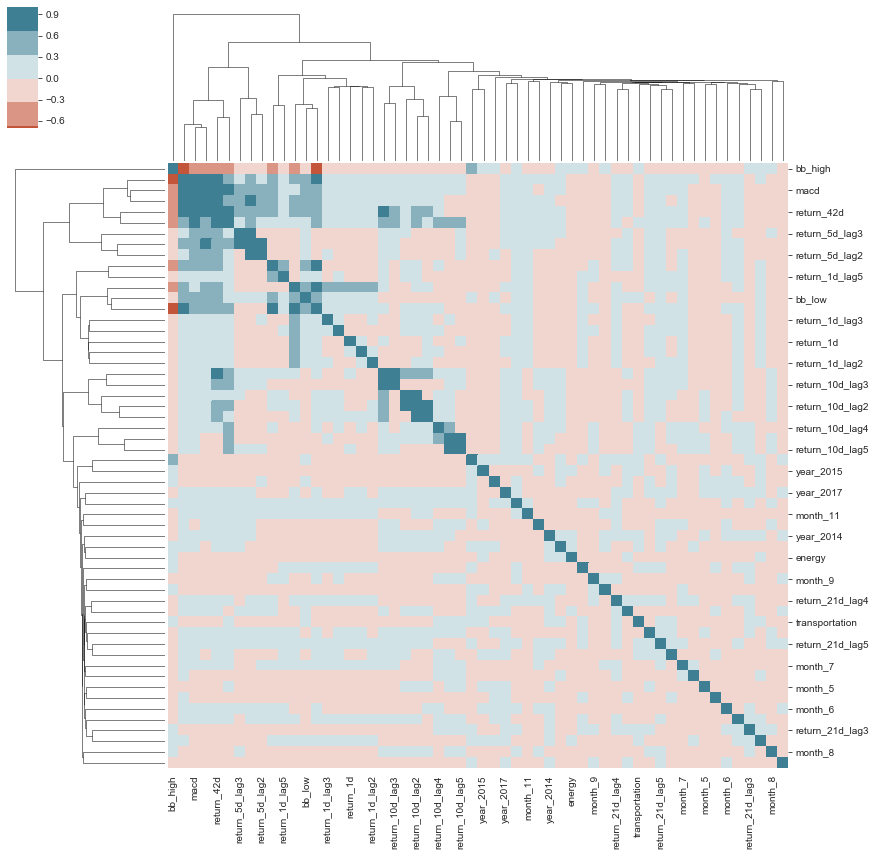

In [8]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [9]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [10]:
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
569,return_63d,return_42d,0.833846
514,return_42d,return_63d,0.833846
4,rsi,macd,0.817994
224,macd,rsi,0.817994
232,macd,return_21d,0.803758
449,return_21d,bb_high,-0.624590
63,bb_high,return_10d,-0.692115
393,return_10d,bb_high,-0.692115
56,bb_high,rsi,-0.701981
1,rsi,bb_high,-0.701981


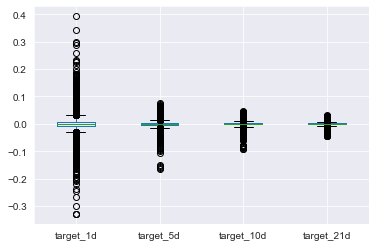

In [11]:
y.boxplot();

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [37]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109667 entries, (AAL, 2013-07-25 00:00:00) to (ZTS, 2014-12-04 00:00:00)
Data columns (total 10 columns):
capital_goods            109667 non-null uint8
consumer_non-durables    109667 non-null uint8
consumer_services        109667 non-null uint8
energy                   109667 non-null uint8
finance                  109667 non-null uint8
health_care              109667 non-null uint8
miscellaneous            109667 non-null uint8
public_utilities         109667 non-null uint8
technology               109667 non-null uint8
transportation           109667 non-null uint8
dtypes: uint8(10)
memory usage: 1.6+ MB


### 1-Day Returns

In [12]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     17.67
Date:                Sat, 16 Nov 2019   Prob (F-statistic):          5.94e-170
Time:                        22:38:27   Log-Likelihood:             2.9037e+05
No. Observations:              109667   AIC:                        -5.806e+05
Df Residuals:                  109610   BIC:                        -5.801e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### 5-Day Returns

In [16]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     54.05
Date:                Sun, 17 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:23:29   Log-Likelihood:             3.8082e+05
No. Observations:              109667   AIC:                        -7.615e+05
Df Residuals:                  109614   BIC:                        -7.610e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

#### Obtain the residuals

In [17]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds

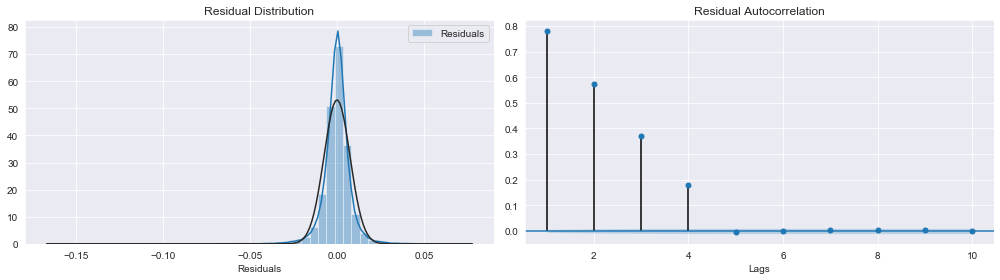

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
fig.tight_layout()
fig.savefig('figures/ols_residuals', dpi=300);

KeyboardInterrupt: 

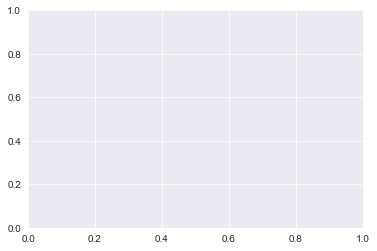

In [28]:
graphics.influence_plot(trained_model, criterion="cooks")

### 10-Day Returns

In [14]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     80.22
Date:                Sat, 16 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:38:45   Log-Likelihood:             4.2120e+05
No. Observations:              109667   AIC:                        -8.423e+05
Df Residuals:                  109610   BIC:                        -8.417e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Monthly Returns

In [15]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     126.8
Date:                Sat, 16 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:38:49   Log-Likelihood:             4.6494e+05
No. Observations:              109667   AIC:                        -9.298e+05
Df Residuals:                  109610   BIC:                        -9.292e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00